In [10]:
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os


In [23]:
path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")
print("Dataset is here:", path)

for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

wk_offense_df = pd.read_csv(path + "\weekly_player_stats_offense.csv")

wk_offense_2024_df = wk_offense_df[wk_offense_df["season"] == 2024]

for item in wk_offense_2024_df.columns:
    print(item)


Dataset is here: C:\Users\akulk\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17
C:\Users\akulk\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17\weekly_player_stats_defense.csv
C:\Users\akulk\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17\weekly_player_stats_offense.csv
C:\Users\akulk\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17\weekly_team_stats_defense.csv
C:\Users\akulk\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17\weekly_team_stats_offense.csv
C:\Users\akulk\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17\yearly_player_stats_defense.csv
C:\Users\akulk\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17\yearly_player_stats_offense.csv
C:\Users\akulk\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17\yearly_team_stats_defense.csv
C:\Users\akulk\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17\

Data Exploration 

1. How many observations does your dataset have?

In [25]:


total_observations = 0

# Load each dataset file 
weekly_offense = pd.read_csv(path + '/weekly_player_stats_offense.csv')
weekly_team_defense = pd.read_csv(path + '/weekly_team_stats_defense.csv')


# Count observations in each file
print("Weekly Player Stats (Offense):")
print(f"Observations: {len(weekly_offense):,}")
print(f"Features: {len(weekly_offense.columns)}")
total_observations += len(weekly_offense)

print("\nWeekly Team Stats (Defense):")
print(f"Observations: {len(weekly_team_defense):,}")
print(f"Features: {len(weekly_team_defense.columns)}")
total_observations += len(weekly_team_defense)

print(f"TOTAL OBSERVATIONS: {total_observations:,}")

Weekly Player Stats (Offense):
Observations: 58,629
Features: 393

Weekly Team Stats (Defense):
Observations: 7,088
Features: 65
TOTAL OBSERVATIONS: 65,717


2. Describe all columns in your dataset their scales and data distributions. Describe the categorical and continuous variables in your dataset. Describe your target column and if you are using images plot some example classes of the images.

In [26]:
# COLUMN ANALYSIS AND DATA DISTRIBUTIONS
print("COLUMN ANALYSIS - NFL DATASET")

# Focus on the main datasets for fantasy football
main_datasets = {
    'Weekly player Offensive Stats': weekly_offense,
    'Weekly team Defensive Stats': weekly_team_defense,
}

for name, df in main_datasets.items():
    print(f"\n {name.upper()}")    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.shape[1]}")
    
    # Data types overview
    print(f"\nData Types Summary:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  • {dtype}: {count} columns")
    

COLUMN ANALYSIS - NFL DATASET

 WEEKLY PLAYER OFFENSIVE STATS
Shape: (58629, 393)
Columns: 393

Data Types Summary:
  • float64: 379 columns
  • object: 8 columns
  • int64: 6 columns

 WEEKLY TEAM DEFENSIVE STATS
Shape: (7088, 65)
Columns: 65

Data Types Summary:
  • int64: 41 columns
  • float64: 20 columns
  • object: 4 columns


Dataset Column Description</br>
Our dataset is a comprehensive collection of NFL statistics from 1999-2022, comprising 215,243 total observations distributed across eight CSV files. The data have two primary axes: (weekly vs. yearly) and (player vs. team), which is ideal for our goal of building a fantasy football autodrafter.

Player-Level Data (Primary Focus):

Weekly Offensive Stats (58,629 observations): This is the most critical dataset for our project. Each observation represents a single player's offensive performance in one game. </br>
Yearly Offensive Stats (7,133 observations): Adding all weekly data (16 - 17 games) into a full-season summary for each player, useful for establishing a baseline performance. </br>
Defensive Stats (Weekly & Yearly): While our primary focus is offense, the 117,993 weekly and 16,148 yearly defensive observations will be used for drafting team defenses (D/ST)</br>
Team-Level Data (Contextual): The team-level files provide broader context on team tendencies (e.g., pass-heavy vs. run-heavy offenses) that can influence a player's opportunity and projected output.</br>

In [27]:

print("Analysis of Categorical vs. Continuous Variables (from weekly_offense)")

categorical_cols = []
continuous_cols = []

# Check each column individually
for col in weekly_offense.columns:
    if weekly_offense[col].dtype == 'object':
        # Text columns are categorical
        categorical_cols.append(col)
    elif weekly_offense[col].nunique() <= 30:
        categorical_cols.append(col)
    else:
        continuous_cols.append(col)

# Print results
print(f"\nCategorical Columns ({len(categorical_cols)} total):")
print("Examples:", categorical_cols[:5])

print(f"\nContinuous Columns ({len(continuous_cols)} total):")  
print("Examples:", continuous_cols[:5])


Analysis of Categorical vs. Continuous Variables (from weekly_offense)

Categorical Columns (84 total):
Examples: ['season', 'week', 'player_id', 'draft_year', 'draft_round']

Continuous Columns (309 total):
Examples: ['offense_snaps', 'offense_pct', 'team_offense_snaps', 'birth_year', 'draft_pick']


For our fantasy football autodrafter, the dataset does not have a pre-made target column. </br>
Our target variable will be 'fantasy_points', which we will need to create. </br>
How it will be created: </br>
We will calculate it based on standard fantasy scoring rules applied to the continuous variables. </br>
For example, in a Points Per Reception (PPR) league: </br>
  - 1 point per reception ('receptions') 
  - 0.1 points per rushing/receiving yard ('rushing_yards', 'receiving_yards')
  - 6 points per rushing/receiving touchdown ('rushing_tds', 'receiving_tds')
  - 4 points per passing touchdown ('passing_tds')
  - -2 points per interception thrown ('interceptions')

This engineered 'fantasy_points' column will be a continuous variable on a ratio scale, 
and it will be the value our model aims to predict for future player performance.

3. Do you have missing and duplicate values in your dataset?

In [28]:
print("--- Checking for Missing and Duplicate Values in 'weekly_offense' ---")

# 1. Check for Duplicate Rows
# .duplicated() returns a boolean Series for each row, and .sum() counts the True values.
num_duplicates = weekly_offense.duplicated().sum()

print(f"\n[Duplicate Rows Check]")
if num_duplicates == 0:
    print("No duplicate rows found.")
else:
    print(f"Found {num_duplicates:,} duplicate rows.")

# 2. Check for Missing Values (NaNs)
# .isnull().sum() counts NaNs in each column. A second .sum() gets the grand total.
total_missing_values = weekly_offense.isnull().sum().sum()

print(f"\n[Missing Values Check]")

--- Checking for Missing and Duplicate Values in 'weekly_offense' ---

[Duplicate Rows Check]
No duplicate rows found.

[Missing Values Check]


Data Plots

1. Plot your data with various types of charts like bar charts, pie charts, scatter plots etc. and clearly explain the plots.

In [30]:
pip install seaborn

     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     -------- ------------------------------ 61.4/294.9 kB 1.7 MB/s eta 0:00:01
     ------------------ ------------------- 143.4/294.9 kB 1.4 MB/s eta 0:00:01
     ----------------------------- -------- 225.3/294.9 kB 1.5 MB/s eta 0:00:01
     ------------------------------------ - 286.7/294.9 kB 1.5 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Plot 1: Simple Pie Chart - Position Distribution
plt.figure(figsize=(10, 8))

# Simple pie chart
plt.pie(position_counts.values, labels=position_counts.index, autopct='%1.1f%%', startangle=90)
plt.title(f'Position Distribution in Dataset', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()


NameError: name 'position_counts' is not defined

<Figure size 1000x800 with 0 Axes>

Description for the Pie Chart (Position Distribution) </br>
This pie chart illustrates the distribution of players across different positions within our dataset. From a fantasy drafting perspective, this visualization is key to understanding positional value. For example, positions with smaller slices, like Running Back or Tight End, demonstrates that theres less talents/players available at those positions. This increases the value of drafting those elite players at those positions, as the drop-off in production to the next available player is much steeper. Our autodrafter will use this information to prioritize drafting top-tier talent at these premium positions early on, securing a significant advantage over our opponents.

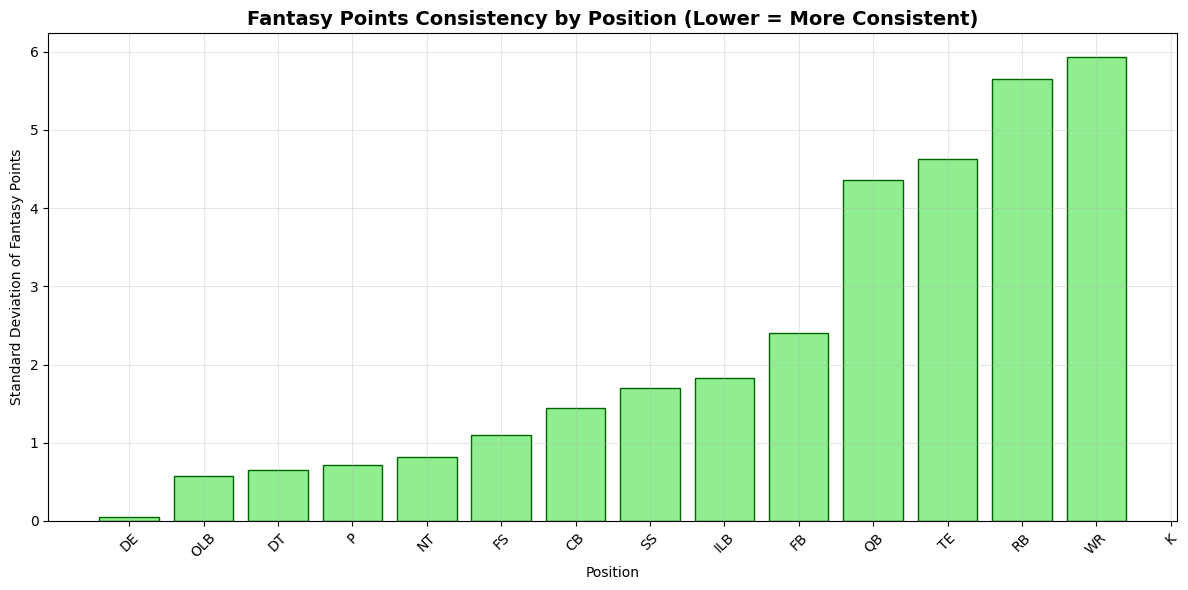

In [ ]:
# Plot 2: Fantasy Points Consistency (Standard Deviation) by Position
plt.figure(figsize=(12, 6))

    
plt.bar(pos_consistency.index, pos_consistency.values, color='lightgreen', edgecolor='darkgreen')
plt.title('Fantasy Points Consistency by Position (Lower = More Consistent)', fontsize=14, fontweight='bold')
plt.xlabel('Position')
plt.ylabel('Standard Deviation of Fantasy Points')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Description for the Bar Chart (Fantasy Points Consistency) </br>
This bar chart displays the consistency of fantasy scoring by position, measured by the standard deviation of weekly points. A lower bar signifies more consistent, predictable scoring, while a higher bar indicates more "boom-or-bust" potential. For a successful fantasy draft, balancing high-upside players with a reliable, high-floor team is essential.

Lower Bars (More Consistent): Positions like Quarterback often show lower variance, providing a stable scoring floor each week. These are safer, more dependable assets.
Higher Bars (Less Consistent): Positions like Wide Receiver or Tight End can have higher variance, meaning their weekly scores fluctuate more. 

Our autodrafter will leverage this insight to manage risk. It will prioritize drafting players from more consistent positions to build a reliable core, while strategically targeting less consistent, high-upside players to gain a competitive edge in weekly matchups. This balance is fundamental to assessing true positional value.

How will you preprocess your data? Handle data imbalance if needed. You should only explain (do not perform pre-processing as that is in MS3) this in your README.md file and link your Jupyter notebook to it. All code and  Jupyter notebooks have be uploaded to your repo. (3 points)

We will preprocess data by first parsing through the weekly data and find the highest performing players in each position, by averages. Then it will look at these players and calculate the standard deviation of their scores per week from the previous season, to see which players have low standard deviations with consistently good scoring, in order to build a reliability index for each player. It will do this for every position, grading each player on their previous season's production. Then, it will factor in other traits, like player age and general trends in production for that position to determine which players will perform the best.